# 6.6 卷积神经网络（LeNet）
- **目录**
  - 6.6.1 LeNet
  - 6.6.2 模型训练


通过之前几节，我们学习了构建一个完整卷积神经网络的所需组件。
回想一下，之前我们将softmax回归模型（3.6节）和多层感知机模型（4.2节）应用于Fashion-MNIST数据集中的服装图片。
为了能够应用softmax回归和多层感知机，我们首先将每个大小为$28\times28$的图像展平为一个784维的固定长度的一维向量，然后用全连接层对其进行处理。
而现在，我们已经掌握了卷积层的处理方法，我们可以**在图像中保留空间结构**。
同时，用卷积层代替全连接层的另一个好处是：模型更简洁、所需的参数更少。

在本节中，我们将介绍LeNet，它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。
这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像中的手写数字。
当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。

当时，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。
LeNet被广泛用于自动取款机（ATM）机中，帮助识别处理支票的数字。
时至今日，一些自动取款机仍在运行Yann LeCun和他的同事Leon Bottou在上世纪90年代写的代码呢！

- **要点：**
  - 通过学习卷积神经网络的组件，我们可以在图像处理中保留空间结构，从而避免将图像展平为一维向量。
  - 使用卷积层代替全连接层可以使模型更简洁，减少参数数量。
  - LeNet是最早发布的卷积神经网络之一，由AT&T贝尔实验室的研究员Yann LeCun于1989年提出，用于识别图像中的手写数字。
  - Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。
  - 当时，LeNet在计算机视觉任务中具有高效性能，与支持向量机（SVM）相媲美，成为监督学习的主流方法。
  - LeNet广泛应用于自动取款机（ATM）以识别处理支票上的数字。部分现代ATM仍在运行Yann LeCun和他的同事Leon Bottou在上世纪90年代编写的代码。

## 6.6.1 LeNet

总体来看，**LeNet（LeNet-5）由两个部分组成：**

* 卷积编码器：由两个卷积层组成;
* 全连接层密集块：由三个全连接层组成。
该架构如图6.6.1所示。
<center>
    <img src="../img/lenet.svg" alt="LeNet中的数据流。输入是手写数字，输出为10种可能结果的概率">
</center>
<center>
   图6.6.1 LeNet中的数据流，输入是手写数字，输出为10种可能结果的概率
</center>

每个卷积块中的基本单元是**一个卷积层、一个sigmoid激活函数和平均池化层** 。请注意，虽然ReLU和最大池化层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用$5\times 5$卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个$2\times2$池化操作（步骤2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。

通过下面的LeNet代码，你会相信用深度学习框架实现此类模型非常简单。我们只需要实例化一个`Sequential`块并将需要的层连接在一起。

In [4]:
%matplotlib inline
import torch
from torch import nn
import numpy as np
from d2l import torch as d2l
'''
（1）第一个卷积层输入通道为1，输出通道是6，5*5的大小，填充2*2行，2*2列，
    padding等于单个整数比如2时，表示填充：顶部2行，底部2行，左边2列，右边2列。
    注意：与池化层不同，卷积层的步幅默认是1，池化层的步幅默认与池化窗口大小相同。
（2）第二个卷积层输入通道为6，输出通道为16。
（3）池化层是不汇总的，因此前面一个卷积层输入通道是多少，
    池化层进行池化操作后的输出通道就是多少。
（4）因此在构建卷积神经网络时，理解输入输出张量维度的计算方式很有必要。
'''
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),    
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.Sigmoid(),    
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

--------------
- **说明：卷积层和池化层输出大小的计算**
$$输出尺寸=\lfloor \frac {输入大小 +2 \times 填充大小 - 卷积核或池化核大小}{步幅}  +1\rfloor$$

  * 第一个卷积层的输出：floor((28+2 * 2-5)/1+1)=28, 注意floor是下取整操作。由于卷积核有6个通道，默认步幅为1，因此输出的是6个(28, 28)的矩阵，或维度为(6, 28, 28)的张量。
  * 第一个平均池化层的输出：floor((28+2 * 0-2)/2+1)=14，注意：池化层不进行汇总，因此输出形状为(6, 14, 14)的张量。
  * 第二个卷积层的输出：floor((14+2 * 0-5)/1+1)=10，有16个通道，因此输出形状为(16, 10, 10)的张量。
  * 第二个平均池化层的输出：floor((10+2 * 0-2)/2+1)=5，与16个通道，因此输出形状为(16, 5, 5)的张量。
  * 展平层输出：16 * 5 * 5=400。后面全连接层就比较容易理解了。
  * 注意上述公式没有考虑dilation参数，即图像膨胀操作后的形状，如果要考虑该操作后的图像形状对卷积和池化操作后的输出大小的影响，可以参考：https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
  * 再强调一遍：卷积层和池化层中的默认步幅是不一样的，前者是1，后者是与核大小一致。
  * 此计算公式比6.3节的公式6.3.2更明确清晰，当然此公式的计算有前提条件：即张量的上下左右填充必须保持一致，当然绝大部分应用都是此种类型。
-----------------

- 对原始模型做了一点**小改动**，去掉了最后一层的高斯激活。除此之外与最初的LeNet-5一致。

- 下面代码将一个大小为$28 \times 28$的单通道（黑白）图像通过LeNet。
 
- 通过在每一层打印输出的形状，可以[**检查模型**]，以确保其操作与图6.6.2一致。

<center>
    <img src="../img/lenet-vert.svg" alt="LeNet 的简化版">
</center>
<center>
    图6.6.2 LeNet 的简化版
</center>

In [5]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


- 请注意：
  - 在整个卷积块中，与上一层相比，每一层特征的高度和宽度都减小了。
  - 第一个卷积层使用2个像素的填充，来补偿$5 \times 5$卷积核导致的特征减少。
  - 相反，第二个卷积层没有填充，因此高度和宽度都减少了4个像素。
  - 随着层叠的上升，通道的数量从输入时的1个，增加到第一个卷积层之后的6个，再到第二个卷积层之后的16个。
  - 同时，每个池化层的高度和宽度都减半。
  - 最后，每个全连接层减少维数，最终输出一个维数与结果分类数相匹配的输出。

## 6.6.2 模型训练

- 看看**LeNet在Fashion-MNIST数据集上的表现**。


In [6]:
'''
一共有60000个训练集样本，小批量的大小为256，则批次数为ceil(60000/256)=235
'''
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [7]:
## 有多少批数据：训练数据有235个小批量，测试数据有40个小批量
len(train_iter),len(test_iter)

(235, 40)

In [8]:
60000/256,10000/256

(234.375, 39.0625)

- 虽然卷积神经网络的参数较少，但与深度的多层感知机相比，它们的计算成本仍然很高，因为每个参数都参与更多的乘法。
- 如果有机会使用GPU，可以加快训练。


- 为了便于评估，需对3.6节中描述的(**`evaluate_accuracy`函数进行轻微的修改**)。
- 由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，需要将其复制到显存中。


In [9]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        ## 与train函数相对应，一个设为训练模式，另一个设为评估模式
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

- 与3.6节中定义的`train_epoch_ch3`不同，在进行正向和反向传播之前，需要将每一小批量数据移动到指定设备（例如GPU）上。
- 如下所示，训练函数`train_ch6`也类似于 3.6节中定义的`train_ch3`。
- 由于将实现多层神经网络，因此将**主要使用高级API**。
- 以下训练函数假定从高级API创建的模型作为输入，并进行相应的优化。
- 使用4.8.2.2节中介绍的Xavier随机初始化模型参数。
- 与全连接层一样，使用交叉熵损失函数和小批量随机梯度下降。


In [10]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        ## 只对稠密层和卷积层里的参数进行初始化。池化层不用，因为没有参数。
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            ## xavier: /ˈzævɪr/ 
            ## 只初始化权重，偏置不需要初始化
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)##将是初始化函数应用到深度网络
    print('training on', device)
    net.to(device)## 将模型的参数转换到某个设备上，主要是GPU可用时
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        '''
        train函数是Sequencial从Modules类继承而来。
        该函数默认将模型设为训练状态，而不是评估状态。
        '''
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            '''
            to函数转换数据类型或设备类型
            >>> tensor.to(cuda0, dtype=torch.float64)
                tensor([[-0.5044,  0.0005],
                [ 0.3310, -0.0584]], dtype=torch.float64, device='cuda:0')
            '''
            X, y = X.to(device), y.to(device)
            ## 前向传播
            y_hat = net(X)
            ## 损失函数的值
            l = loss(y_hat, y)
            ## 反向传播，计算参数梯度
            l.backward()
            ## 使用优化方法，更新参数值
            optimizer.step()
            ## 暂停自动计算梯度，便于计算精度
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            ## 每隔5个小批量显示训练损失和精度
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        ## 测试精度
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [11]:
'''
模型中各层的参数形状。
其中(6, 1, 5, 5)和(16, 6, 5, 5)是两个卷积层的参数，
(5,5)是卷积核的大小，和前文示意图中的参数一致。
'''
for i in range(0,9):
    print(np.shape(list(net.parameters())[i].detach().numpy()))

(6, 1, 5, 5)
(6,)
(16, 6, 5, 5)
(16,)
(120, 400)
(120,)
(84, 120)
(84,)
(10, 84)


- **训练和评估LeNet-5模型**。


loss 0.459, train acc 0.828, test acc 0.812
12792.3 examples/sec on cuda:0


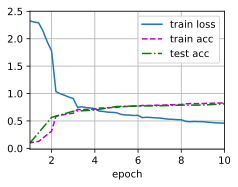

In [12]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [13]:
!nvidia-smi

Sat Sep  7 19:53:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.13                 Driver Version: 556.13         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce MX250         WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   59C    P8             N/A / ERR!  |       0MiB /   2048MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 小结

* 卷积神经网络（CNN）是一类使用卷积层的网络。
* 在卷积神经网络中，我们组合使用卷积层、非线性激活函数和池化层。
* 为了构造高性能的卷积神经网络，我们通常对卷积层进行排列，逐渐降低其表示的空间分辨率，同时增加通道数。
* 在传统的卷积神经网络中，卷积块编码得到的表征在输出之前需由一个或多个全连接层进行处理。
* LeNet是最早发布的卷积神经网络之一。